In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('House_property_preprocessed.csv')
df

,datesold,postcode,price,propertyType,bedrooms,datesold_year,month
0,2007-02-07,2607,13.171154,house,4,2007,2
1,2007-02-27,2906,12.577636,house,3,2007,2
2,2007-03-07,2905,12.700769,house,3,2007,3
3,2007-03-09,2905,12.847927,house,4,2007,3
4,2007-03-21,2906,12.644328,house,3,2007,3
...,...,...,...,...,...,...,...
29575,2019-07-25,2900,13.122363,unit,3,2019,7
29576,2019-07-25,2612,13.235692,unit,2,2019,7
29577,2019-07-26,2912,13.049685,unit,2,2019,7
29578,2019-07-26,2601,13.286181,unit,2,2019,7


# 1 Boosting with classical problem setup

The simplest approach is to see the problem as a classical regression problem, not taking time into account

### 1.1 Convert categorical features

Even though some of them are encoded as integers, in the context of the problem they are categorical variables. Therefore, we will do one hot encoding of them as well

In [2]:
df.dtypes

datesold          object
postcode           int64
price            float64
propertyType      object
bedrooms           int64
datesold_year      int64
month              int64
dtype: object

In [3]:
df1 = df.copy()
df1['postcode'] = df1['postcode'].astype(str)
df1['datesold_year'] = df1['datesold_year'].astype(str)
df1['month'] = df1['month'].astype(str)
df1 = df1.reset_index().drop(['datesold', 'index'], axis=1)
df1 = pd.get_dummies(df1, drop_first=True)
df1.head()

,price,bedrooms,postcode_2601,postcode_2602,postcode_2603,postcode_2604,postcode_2605,postcode_2606,postcode_2607,postcode_2609,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,13.171154,4,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,12.577636,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,12.700769,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,12.847927,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,12.644328,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### 1.2 One more important thing

We will compare the models using MAPE and MAE metrics. This will help us understand the amount by which we are mistaken both in terms of price units and percent. Also, since we took a logarithm of the target, we will take an exponent of both predictions and real values of the logarithm of the target before calculating the metrics

As for model, we will start with CatBoost. I find it as one of the most efficient and convenient implementations of GBM in Python

### 1.3 CatBoost

In [4]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

X = df1.drop(['price'], axis=1)
y = df1[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

model = CatBoostRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print()
print(f'MAPE: {np.round(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)) * 100, 2)}%')
print()
print(f'MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred))}')

Learning rate set to 0.5
0:	learn: 0.2906647	total: 61.3ms	remaining: 552ms
1:	learn: 0.2592036	total: 63.5ms	remaining: 254ms
2:	learn: 0.2414219	total: 65.7ms	remaining: 153ms
3:	learn: 0.2295892	total: 67.6ms	remaining: 101ms
4:	learn: 0.2221437	total: 69.8ms	remaining: 69.8ms
5:	learn: 0.2162124	total: 71.8ms	remaining: 47.9ms
6:	learn: 0.2117817	total: 74ms	remaining: 31.7ms
7:	learn: 0.2089282	total: 76.1ms	remaining: 19ms
8:	learn: 0.2060204	total: 78.4ms	remaining: 8.71ms
9:	learn: 0.2042210	total: 80.3ms	remaining: 0us

MAPE: 14.33%

MAE: 91285.01440783047


So, this is one of the simplest models possible. All we did was OHE. Despite the result is quite good, we cannot trust it, since by predicting values we are looking at the future of the time series, which is impossible in real world. That is why, we need to use special approaches, while working with these datatypes. Most of all, we need to focus on avoiding data leaks, as this will make metrics unreliable and misleading

# 2 Baseline - Boosting, but we will use it smarter

Now we will consider our task as working with time series (not just with ordinary tabular data). This means that we will use lag features, and we will also take into account time dependencies

In [5]:
len(df.loc[df['datesold_year'] == 2019]) / len(df)

0.04682217714672076

I suggest testing on the year of 2019. Even though the size of the testing period is not very big (slightly less than 5%), I find it fine. Years of 2018 and 2019 will take almost 20%, which is a huge number to devote to test set, as our dataset is not very big. Moreover, we will still put some data to validation set (not in the baseline model though)

### 2.0 Why do we need a baseline?

Imagine that we started working on a large project, spent a lot of time on data processing and building a complex model that was supposed to perfectly solve the task. In the end, nothing worked out, but we have already spent a huge amount of time on it. Therefore, in large projects, we should always start with a simple baseline. This will allow us to assess whether the problem is solvable in general, as well as what results we can expect

### 2.1 More detailed data processing and lag features

##### 2.1.1 Creating new datesold index

Since the range of the dates is huge, and we do not have a lot of data points, I suggest creating a new datesold index - with just year and month. 

In [6]:
df2 = df.copy()
df2['day'] = 1
df2 = df2.drop('datesold', axis=1)
df2['datesold'] = pd.to_datetime(dict(year=df2.datesold_year, month=df2.month, day=df2.day))
df2 = df2.drop('day', axis=1)
df2.head()

,postcode,price,propertyType,bedrooms,datesold_year,month,datesold
0,2607,13.171154,house,4,2007,2,2007-02-01
1,2906,12.577636,house,3,2007,2,2007-02-01
2,2905,12.700769,house,3,2007,3,2007-03-01
3,2905,12.847927,house,4,2007,3,2007-03-01
4,2906,12.644328,house,3,2007,3,2007-03-01


##### 2.1.2 Lag features

Lag is a special operator in time series analysis. It is a convenient way to show that we are looking at the value of the same object at a different point in time. It is defined like this:

$$L(y_t) = y_{t-1}$$

We can also put a power on a lag to represent the number of time periods we are looking behind:

$$L^n(y_t) = y_{t-n}$$

We can even look at the future by putting a negative power (people also call this the forward operator, $F(y_t)$):

$$L^{-1}(y_t) = y_{t+1} = F(y_t)$$

However, the forward operator does not make sense in our problem, because we cannot look in the future while doing forecasting

We assume that objects with the same postcode, propertyType, and number of bedrooms are the same. We also want to get the periodicity of one month. Each object can occur several times during one month. So, for such situations, we will just take the average of the price. Remember that we are working with log values, and it is incorrect to take the average of logs, so, we will first take the exponent, then take the average, and after that take the log back

In [7]:
df2 = df2.set_index('datesold')
df2['price'] = np.exp(df2['price'])
df2 = df2.groupby(['postcode', 'propertyType', 'bedrooms', 'datesold_year', 'month'])['price'].mean()
df2 = df2.reset_index()
df2['price'] = np.log(df2['price'])
df2 = df2.sort_values(['datesold_year', 'month', 'postcode', 'propertyType', 'bedrooms'])
df2

,postcode,propertyType,bedrooms,datesold_year,month,price
3027,2607,house,4,2007,2,13.171154
7504,2906,house,3,2007,2,12.577636
7084,2905,house,3,2007,3,12.700769
7226,2905,house,4,2007,3,12.847927
7505,2906,house,3,2007,3,12.644328
...,...,...,...,...,...,...
8723,2913,house,5,2019,7,13.832122
8806,2913,unit,2,2019,7,12.836014
8976,2914,house,3,2019,7,13.076843
9108,2914,house,4,2019,7,13.479727


Now we can plot targets of combinations of factors to search for seasonalities and trends

##### 2.1.3 STL decomposition

In statsmodels we have a built-in technique to decompose a time series to seasonal and trend components. I will not dive into details how it is made. However, doing this might be useful to see the data we are dealing with more clearly. As previously, we will select some propertyTypes, postcodes, and bedrooms to plot the STL decomposition of target related to them

PropertyType=unit, postcode=2600, bedrooms=1


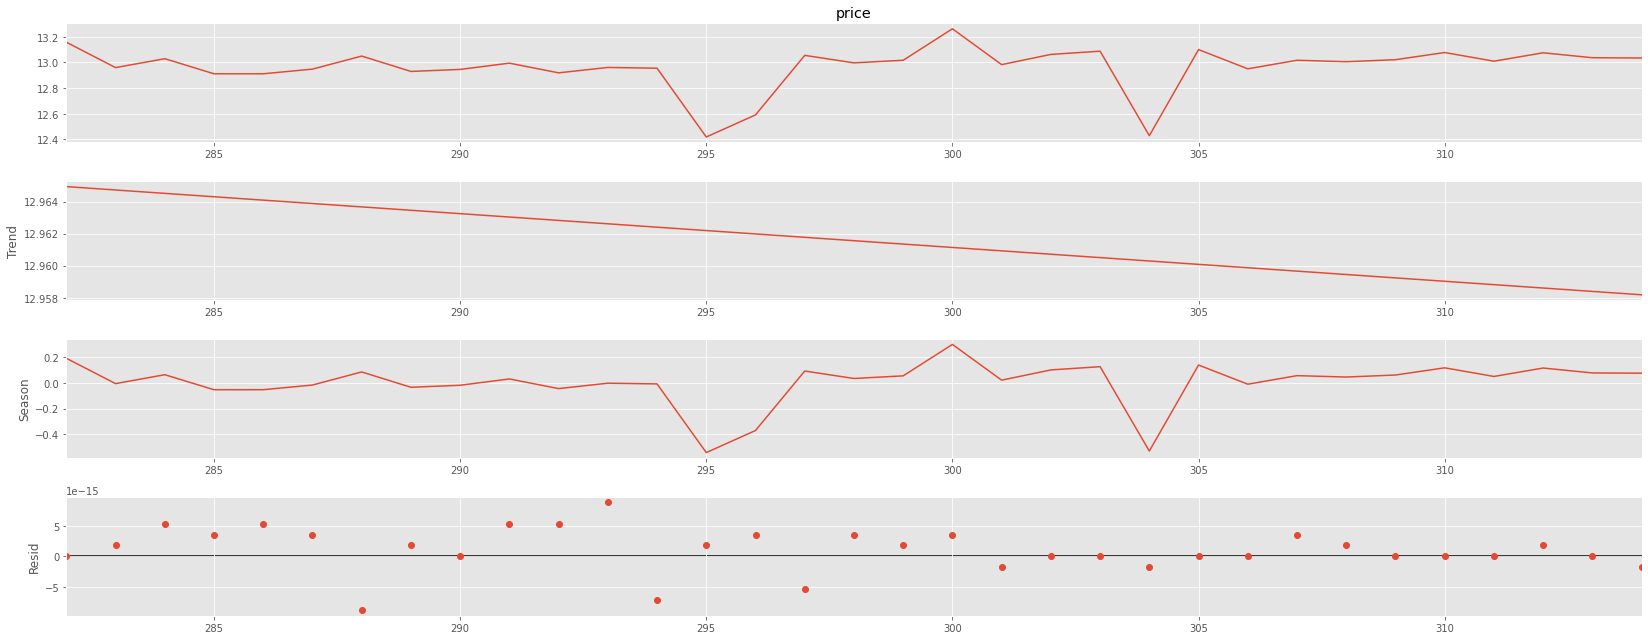



PropertyType=unit, postcode=2612, bedrooms=3


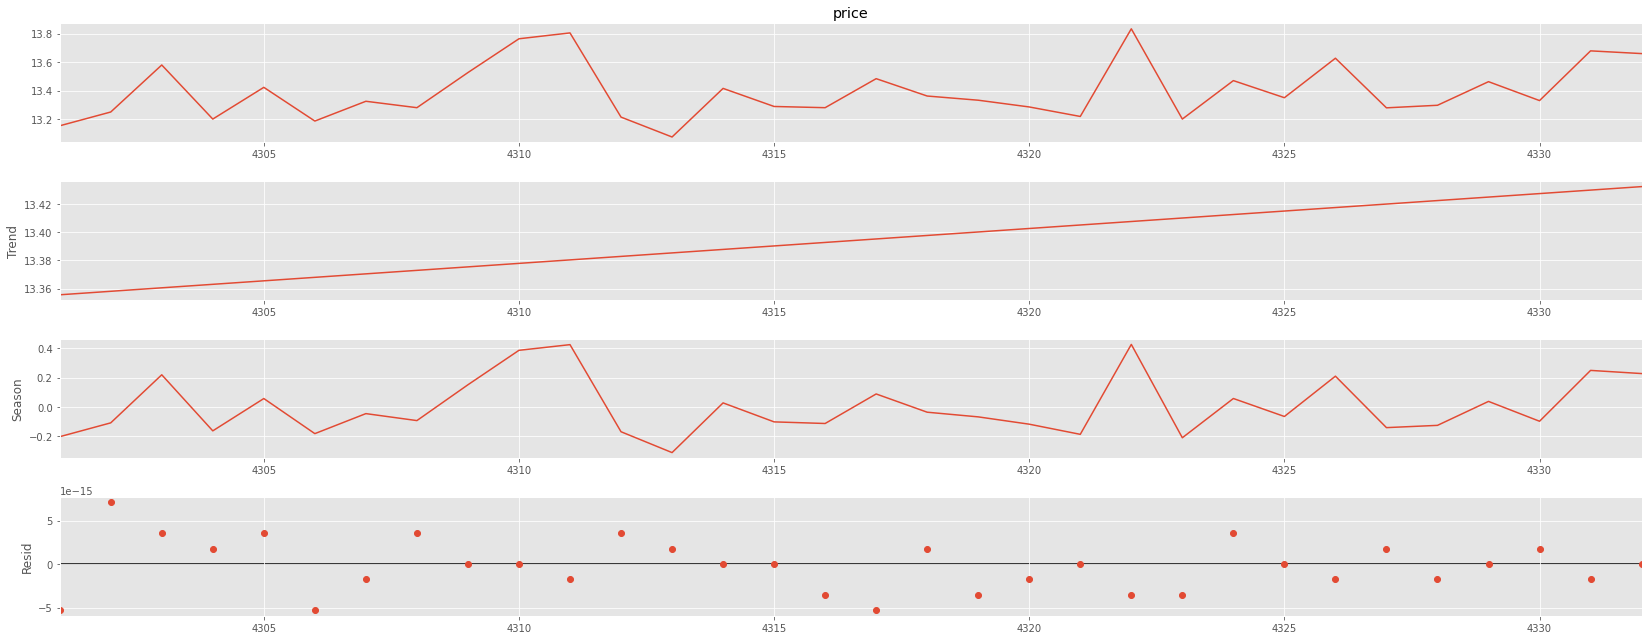



PropertyType=house, postcode=2605, bedrooms=3


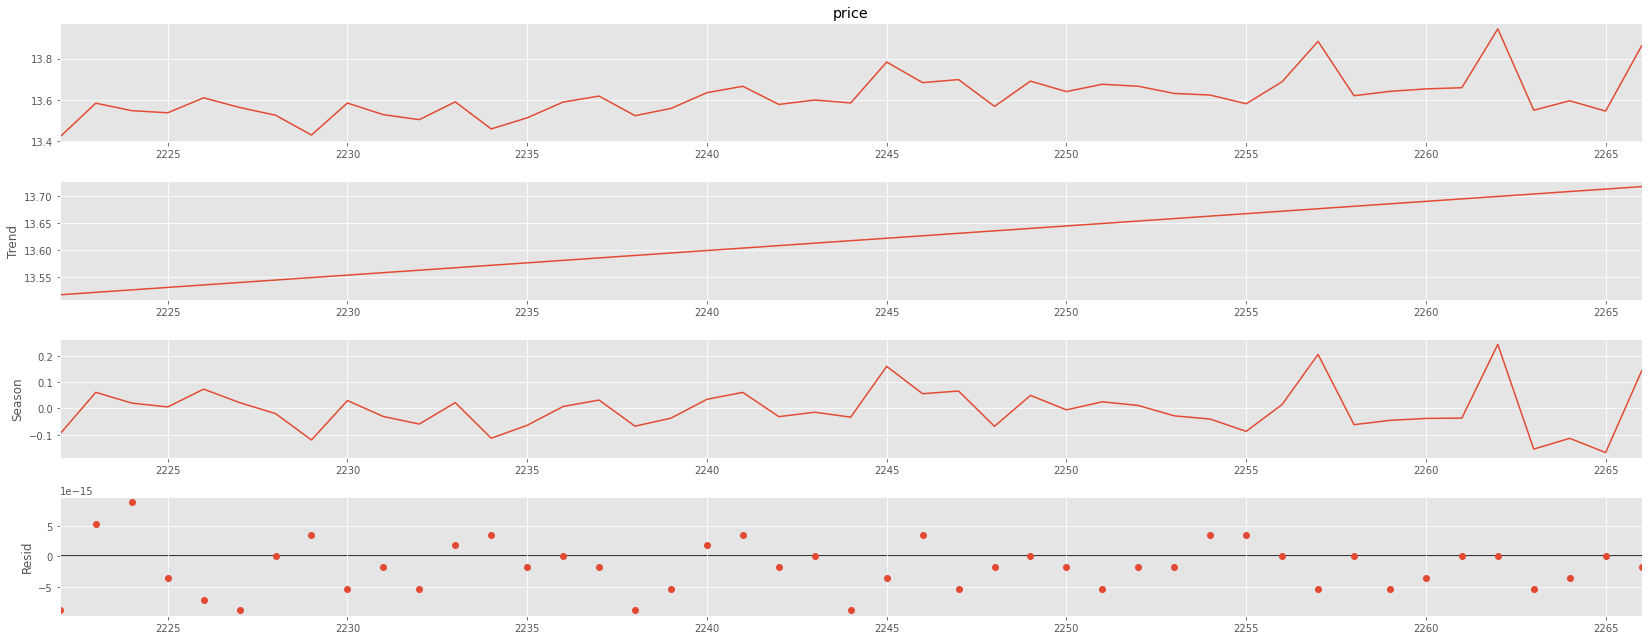



PropertyType=unit, postcode=2606, bedrooms=1


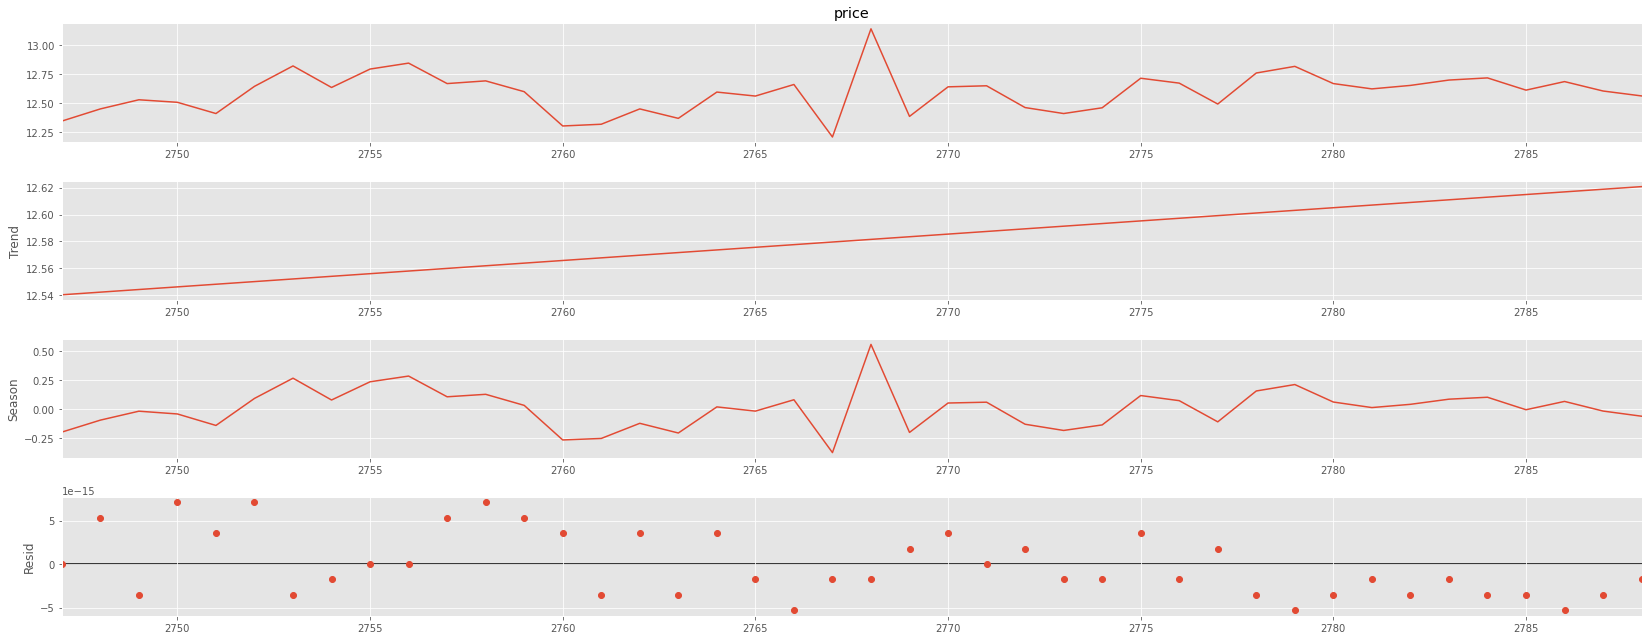



PropertyType=unit, postcode=2913, bedrooms=1


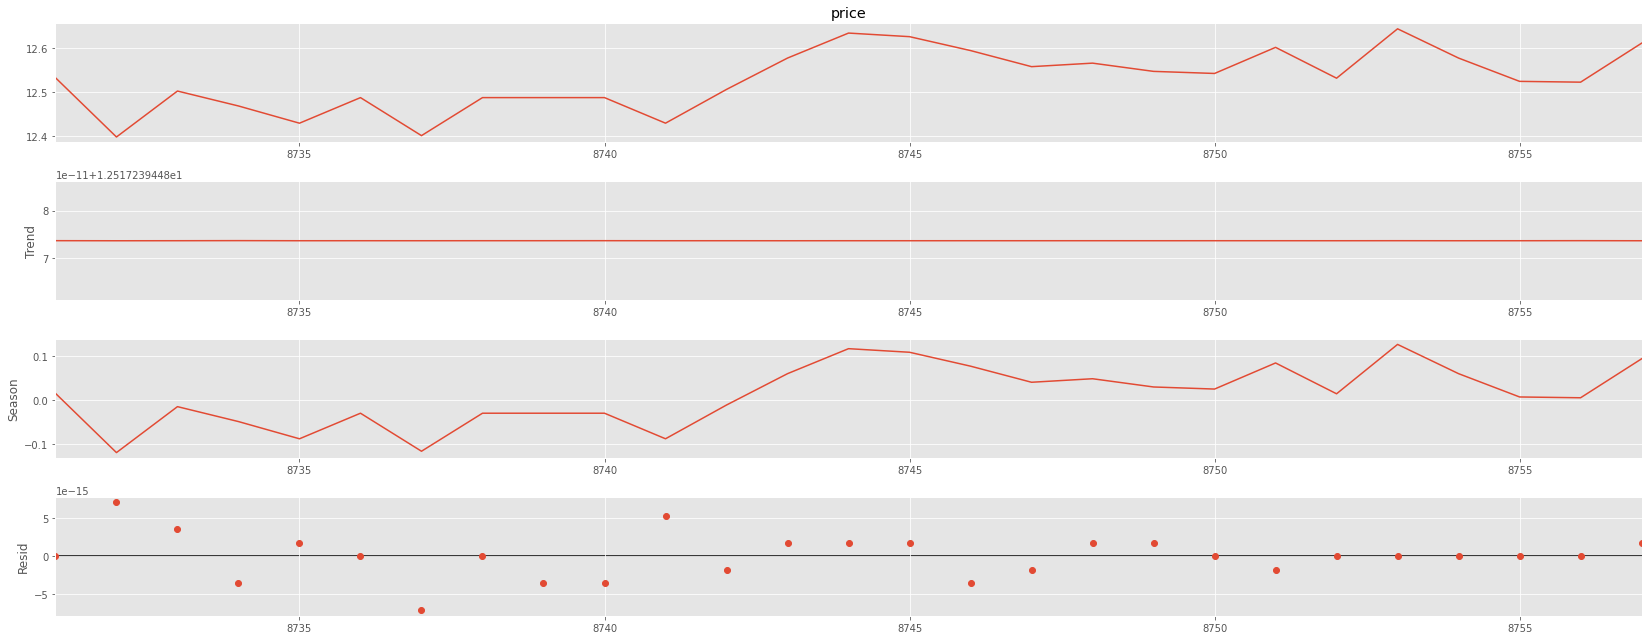



PropertyType=unit, postcode=2604, bedrooms=2


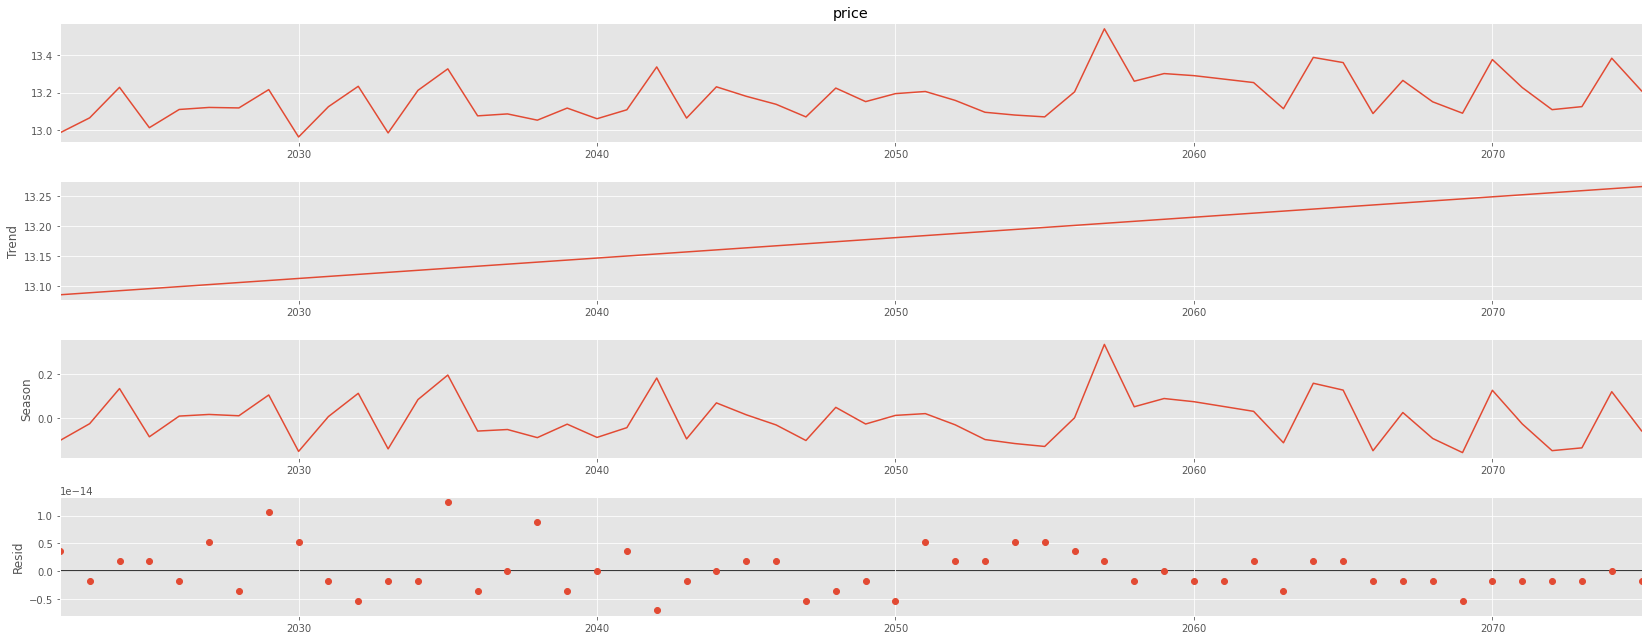



PropertyType=house, postcode=2611, bedrooms=5


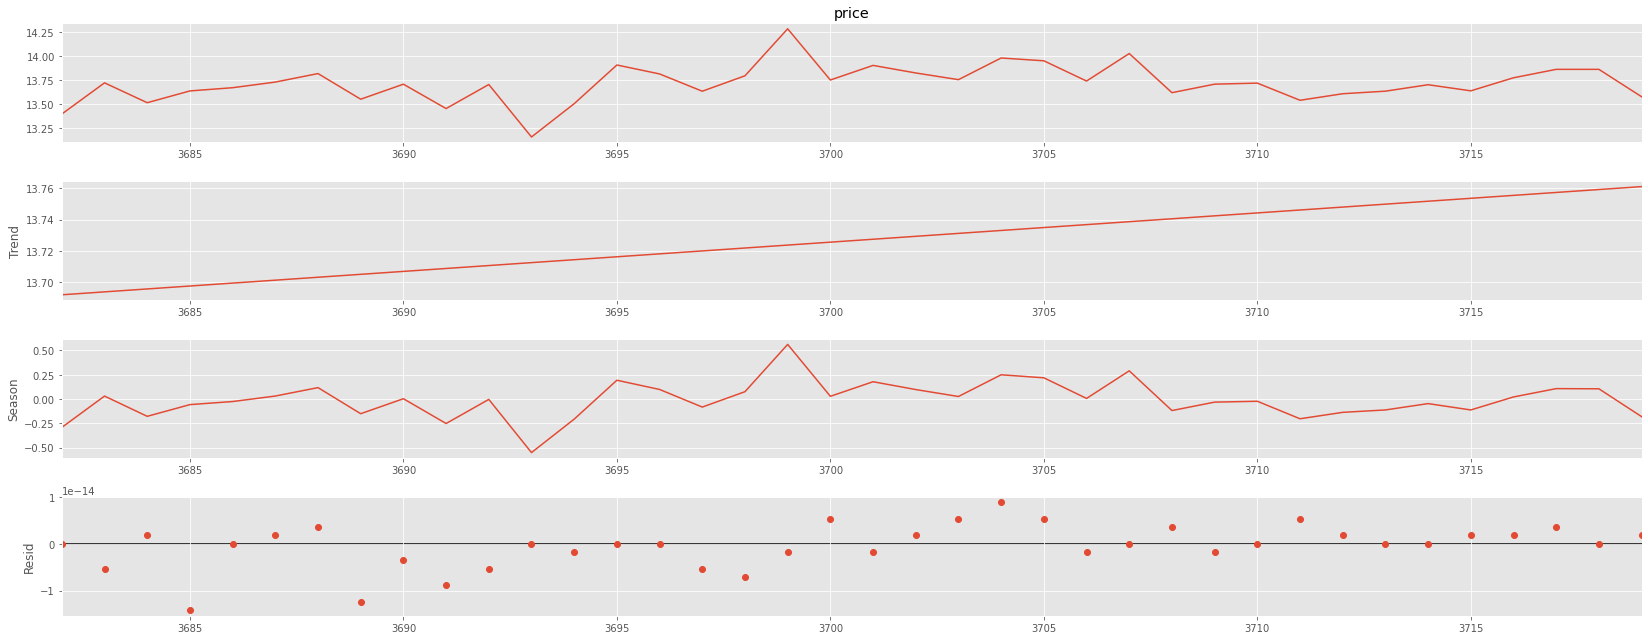



PropertyType=house, postcode=2600, bedrooms=4


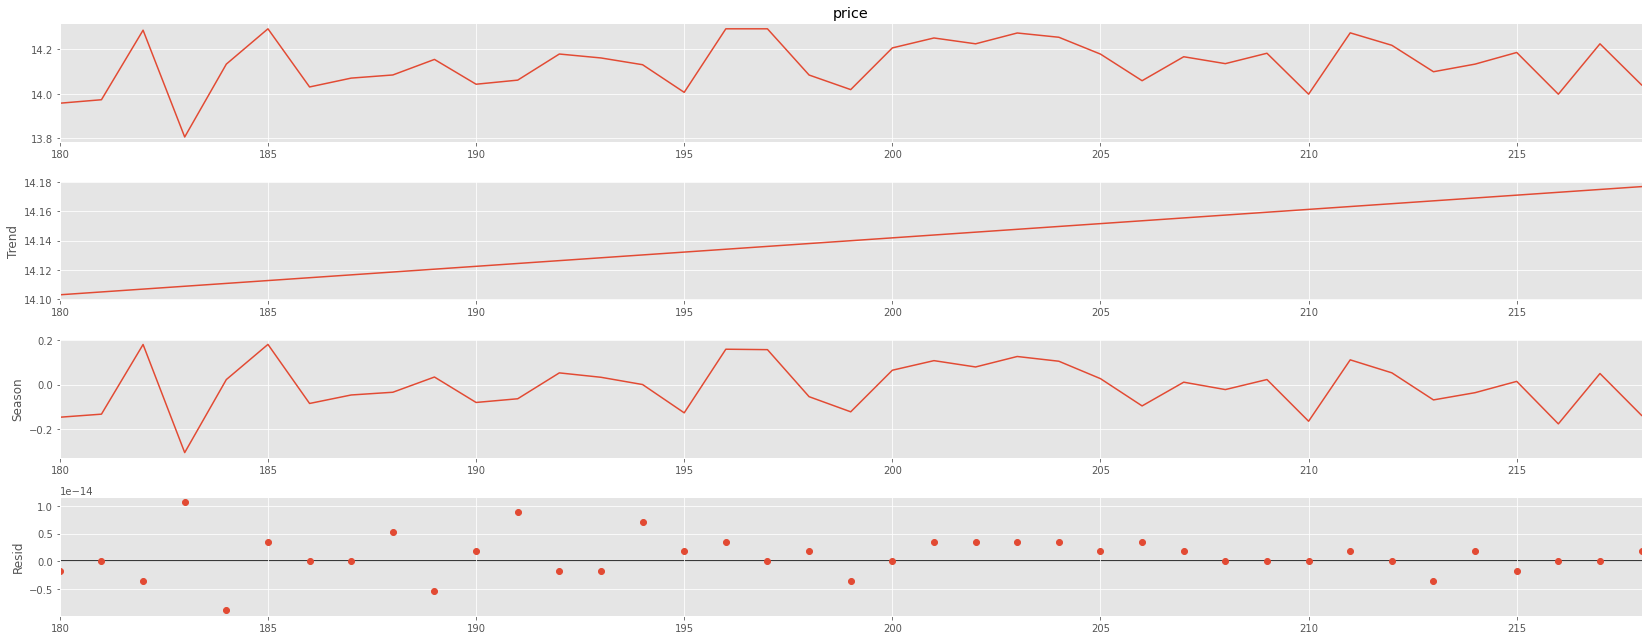



PropertyType=house, postcode=2617, bedrooms=4


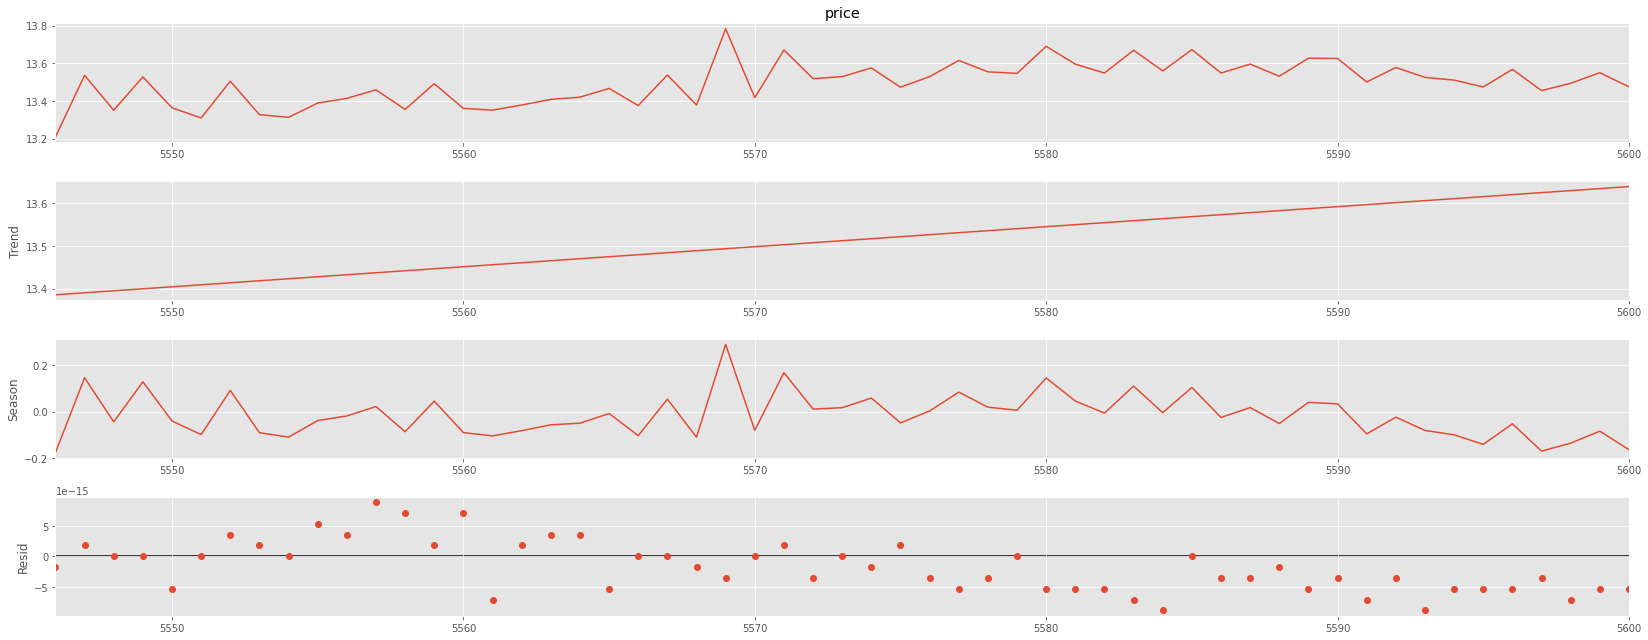



PropertyType=house, postcode=2600, bedrooms=4


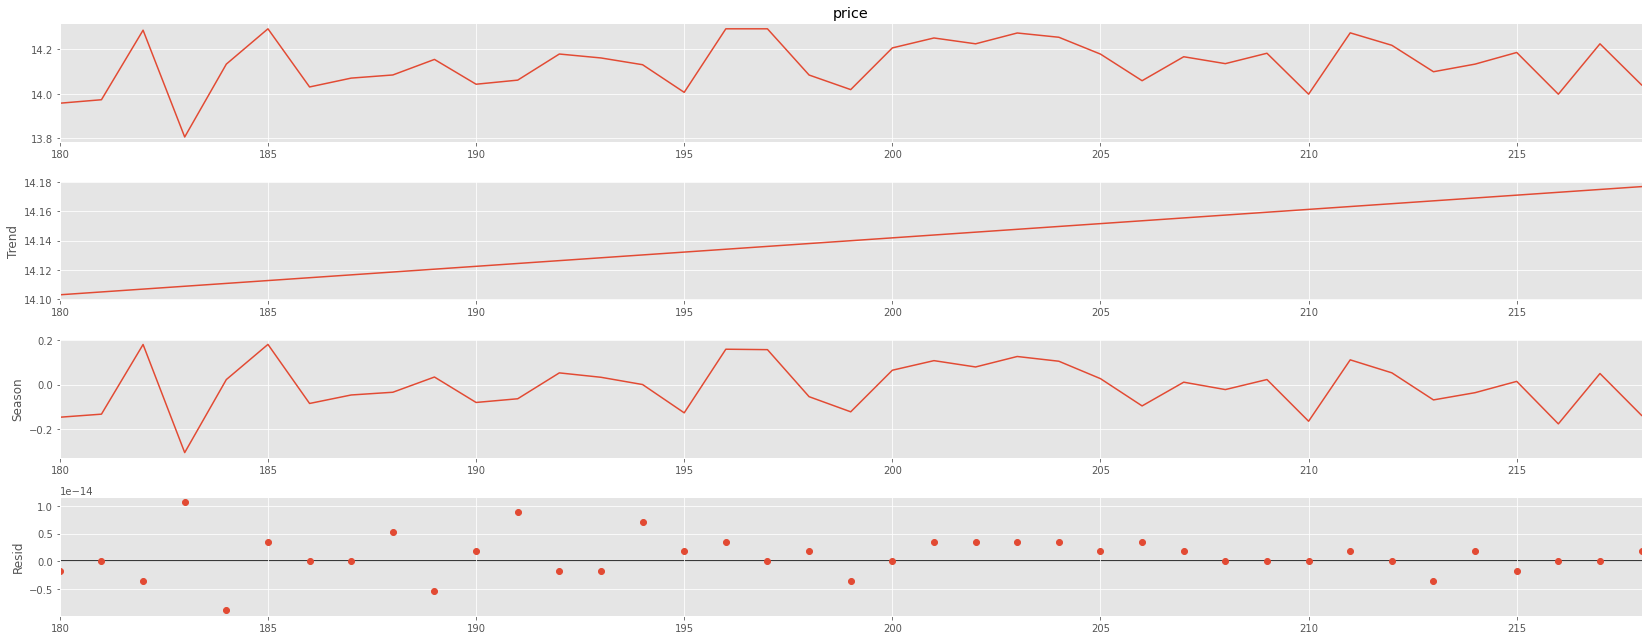



PropertyType=house, postcode=2903, bedrooms=3


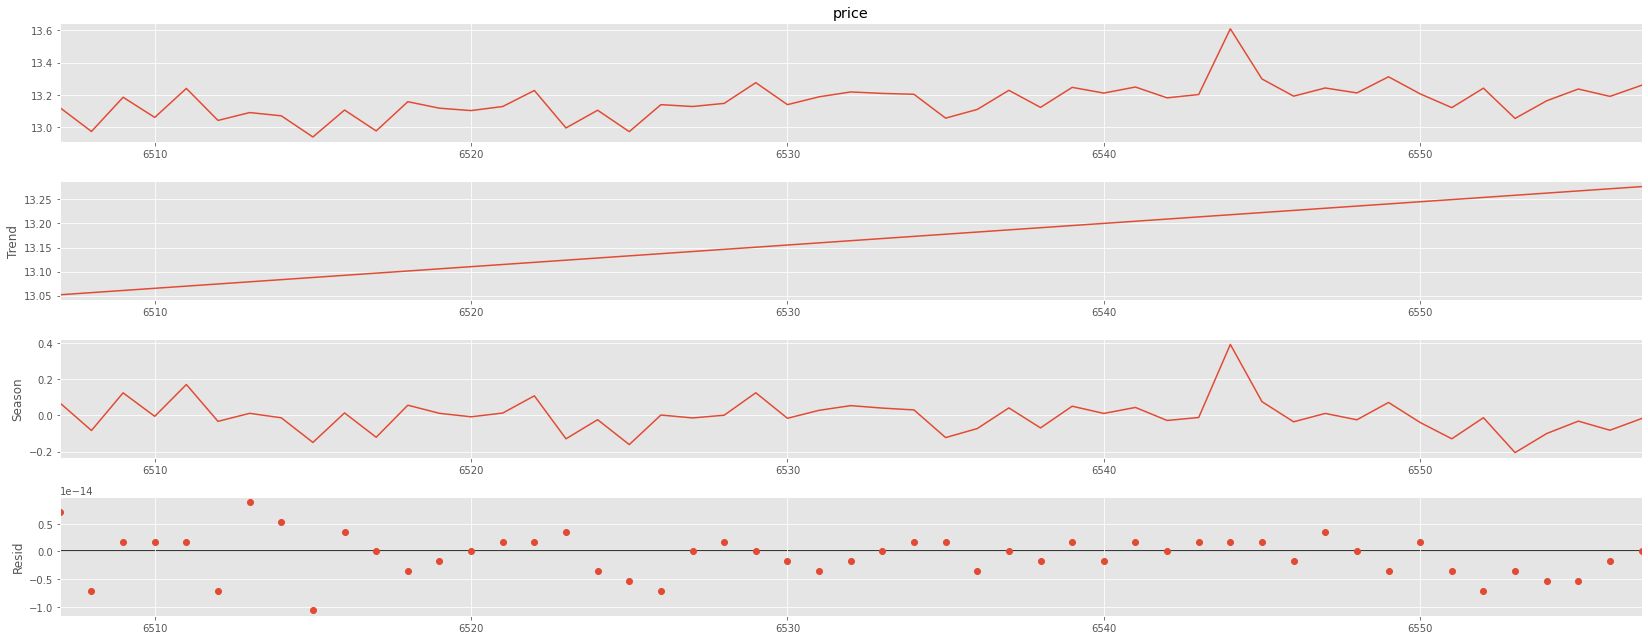



PropertyType=house, postcode=2906, bedrooms=3


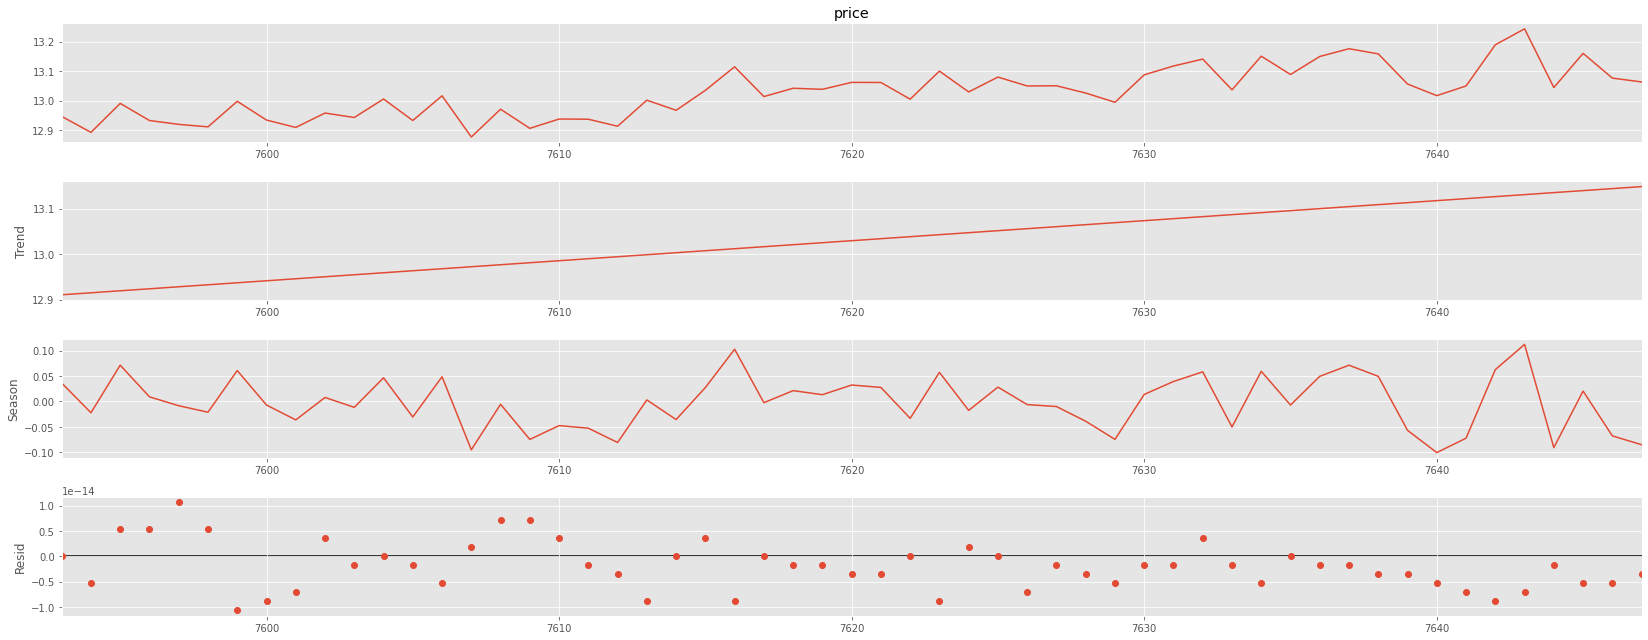



PropertyType=house, postcode=2603, bedrooms=4


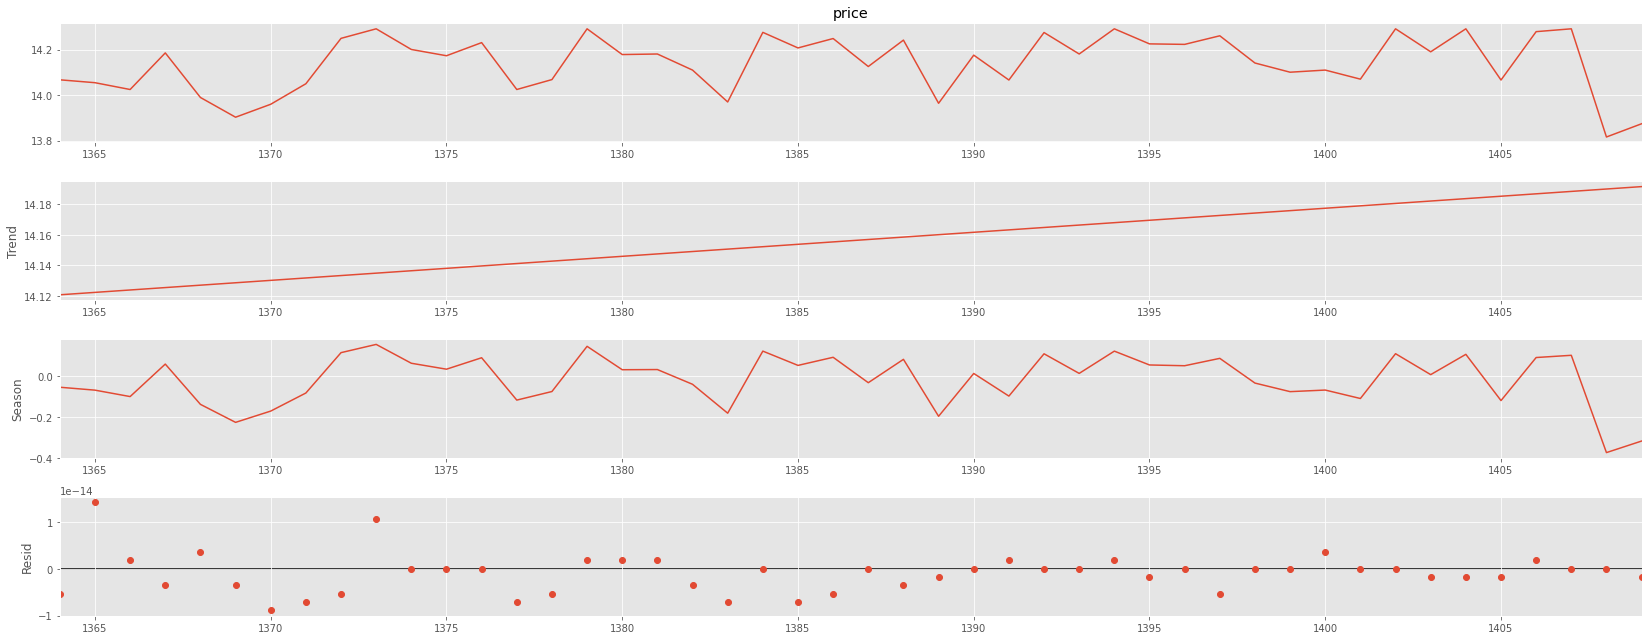



PropertyType=unit, postcode=2617, bedrooms=3


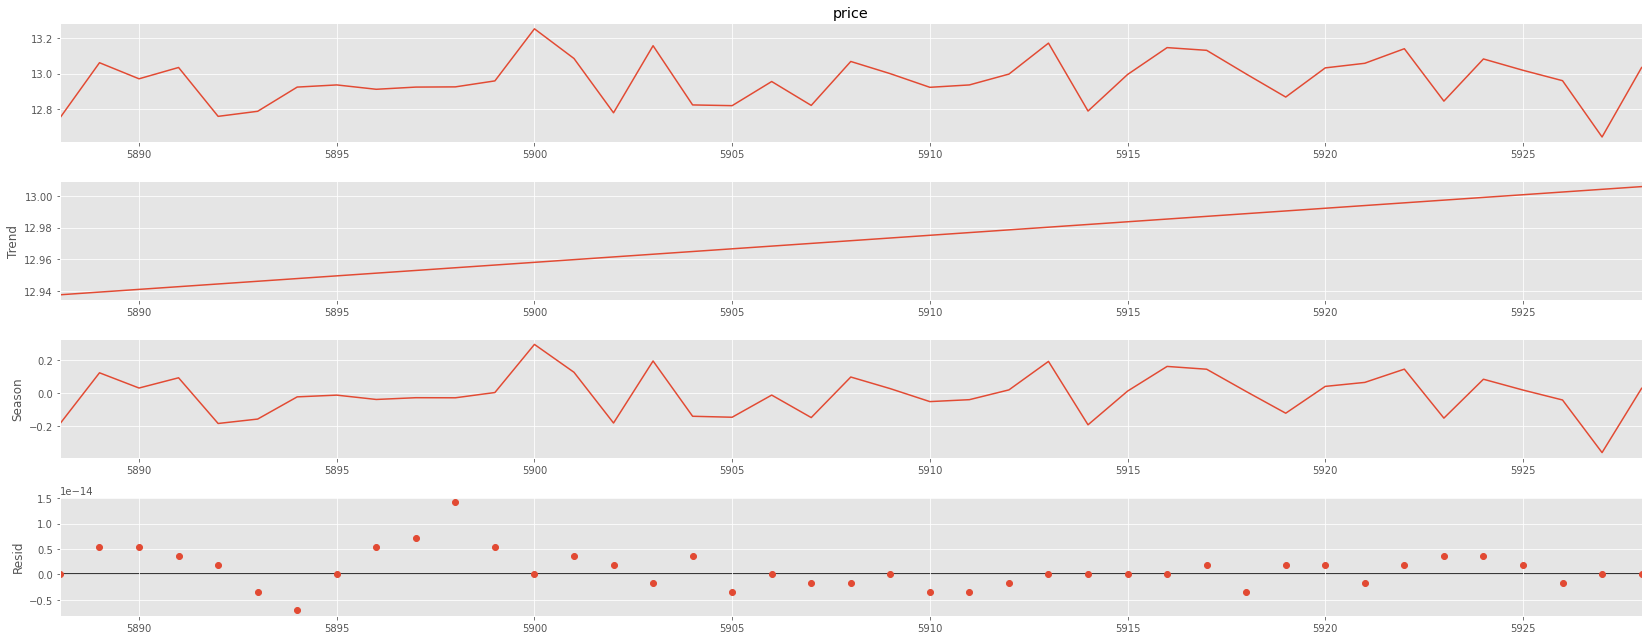



PropertyType=house, postcode=2913, bedrooms=3


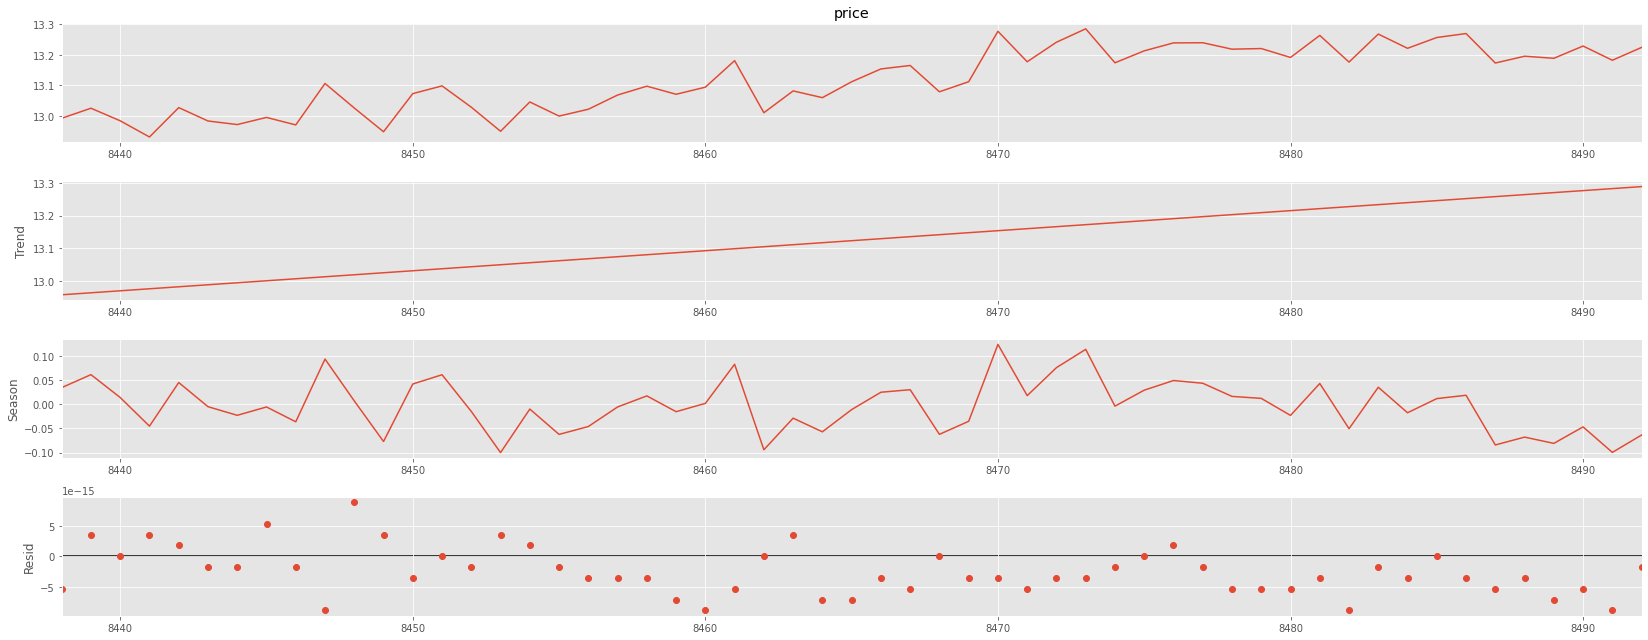



PropertyType=house, postcode=2602, bedrooms=4


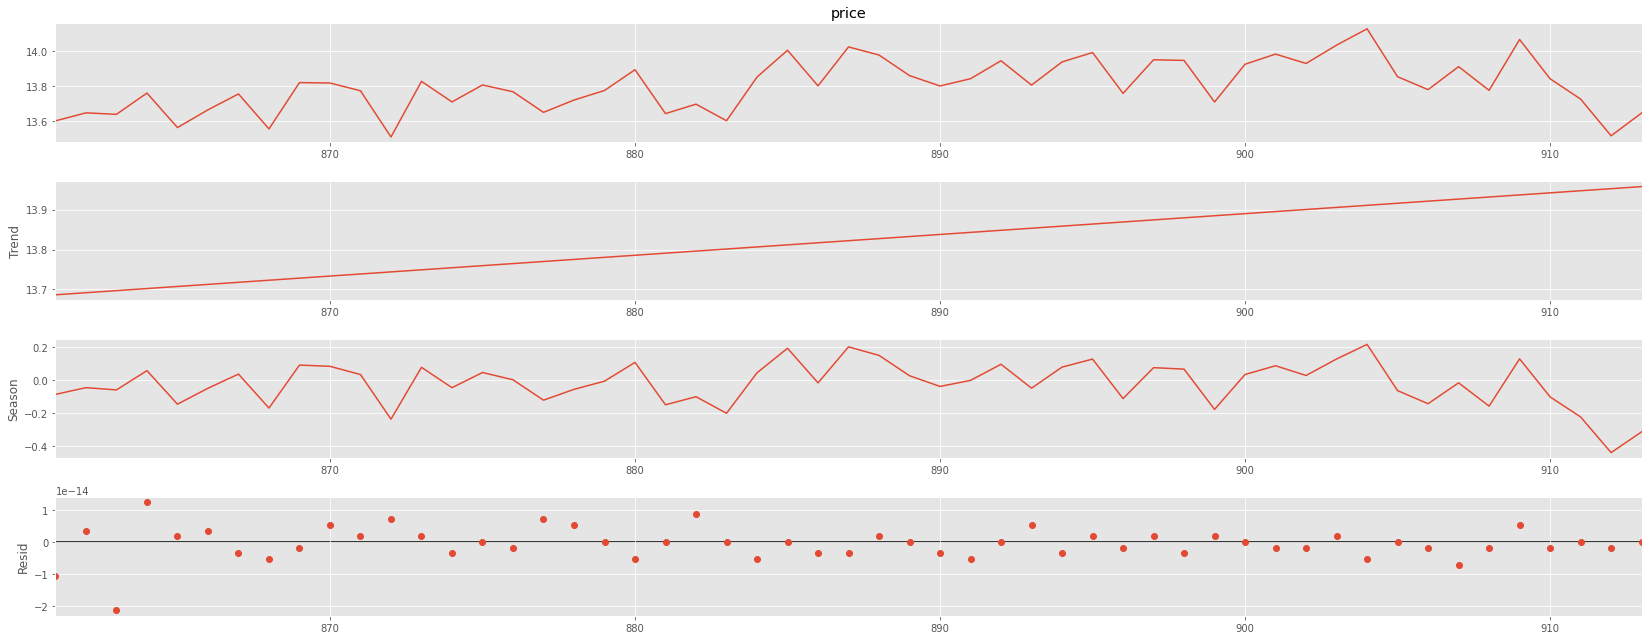



PropertyType=house, postcode=2604, bedrooms=4


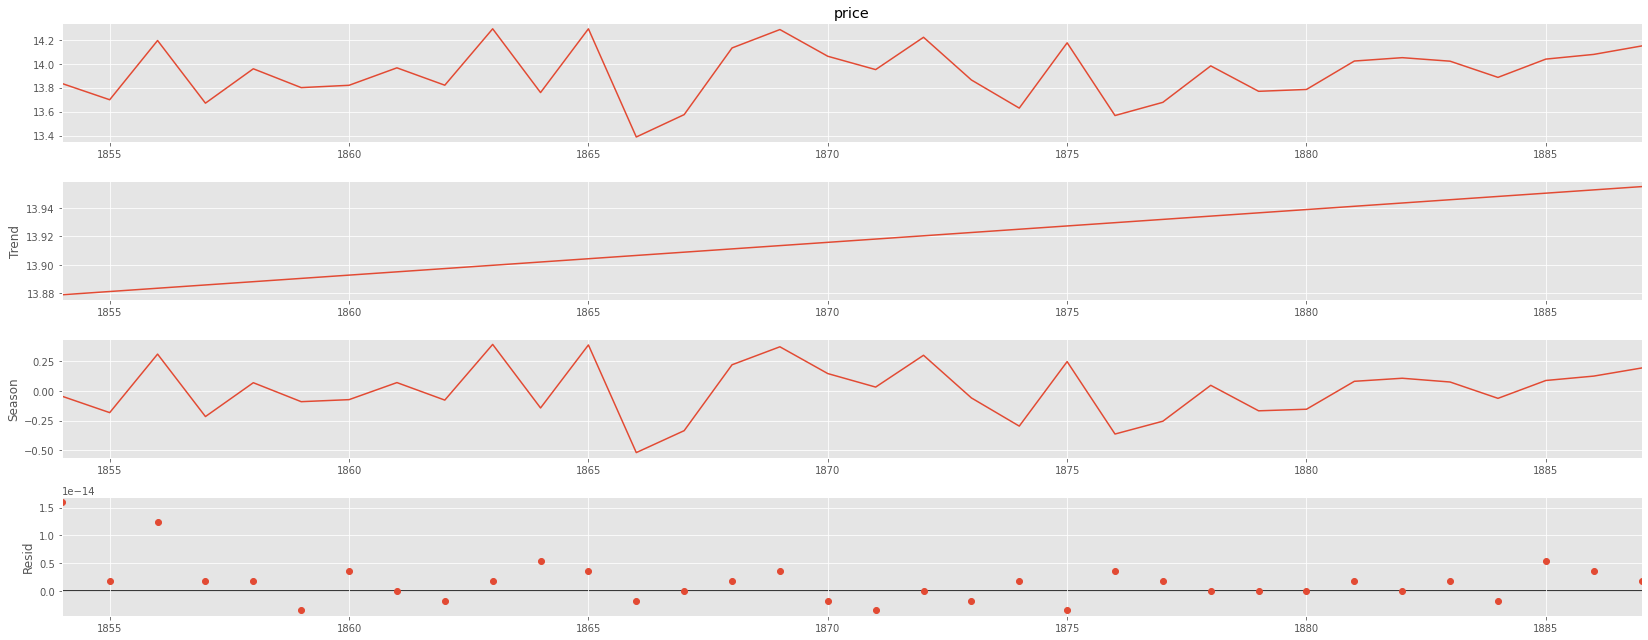

In [8]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

propertyTypes = ['house', 'unit']
postcodes = list(set(df2.postcode.tolist()))
bedrooms = [1,2,3,4,5]

for i in range(50):
    
    property_type = np.random.choice(propertyTypes)
    postcode = np.random.choice(postcodes)
    bedroom = np.random.choice(bedrooms)
    df3 = df2.loc[(df2['propertyType'] == property_type) 
                  & (df2['postcode'] == postcode) 
                  & (df2['bedrooms'] == bedroom)]
    df3 = df3.loc[df3['datesold_year'] >= 2015]
    
    if len(df3) > 25:
        print(f'PropertyType={property_type}, postcode={postcode}, bedrooms={bedroom}')
        stl = STL(df3['price'], seasonal=365, trend=93, period=31)
        res = stl.fit()
        res.plot()
        plt.show()
        print()
        print()

So, at least in most cases we have a trend. As for seasonal component, it is not very clear, but we can still see that there is usually a decline straight after a peak, which is followed by a new peak, and so on. Therefore, it is definetely worth it to use lag features. Using pandas shift, we will create $L, L^2, L^3, L^6, L^{12}, L^{24}, L^{36}$. I do not see the point in looking at more than 3 years back, since this information is unlikely to be relevant

##### 2.1.4 Creating lag features

In [9]:
df2['lag1'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(1)
df2['lag2'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(2)
df2['lag3'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(3)
df2['lag6'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(6)
df2['lag12'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(12)
df2['lag24'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(24)
df2['lag36'] = df2.groupby(['postcode', 'propertyType', 'bedrooms'])['price'].shift(36)
df2

,postcode,propertyType,bedrooms,datesold_year,month,price,lag1,lag2,lag3,lag6,lag12,lag24,lag36
3027,2607,house,4,2007,2,13.171154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7504,2906,house,3,2007,2,12.577636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7084,2905,house,3,2007,3,12.700769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7226,2905,house,4,2007,3,12.847927,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7505,2906,house,3,2007,3,12.644328,12.577636,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,2913,house,5,2019,7,13.832122,13.772603,13.982084,13.864301,13.798873,13.803775,13.527828,13.407542
8806,2913,unit,2,2019,7,12.836014,12.860999,12.709874,12.821258,12.818891,12.860999,12.786891,12.487108
8976,2914,house,3,2019,7,13.076843,13.309120,13.193800,13.239924,13.163185,13.239753,13.252993,13.137580
9108,2914,house,4,2019,7,13.479727,13.601247,13.482084,13.523029,13.521676,13.508850,13.523403,13.405221


#### 2.1.5 Fillna

At least some of GBM implementations in Python can handle the missing variables (CatBoost as well). However, built-in methods might be not very satisfying. I suggest a smarter approach - we will substitute nan values by within group means

In [10]:
df2['lag1'] = df2['lag1'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag1'].transform('mean'))
df2['lag2'] = df2['lag2'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag2'].transform('mean'))
df2['lag3'] = df2['lag3'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag3'].transform('mean'))
df2['lag6'] = df2['lag6'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag6'].transform('mean'))
df2['lag12'] = df2['lag12'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag12'].transform('mean'))
df2['lag24'] = df2['lag24'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag24'].transform('mean'))
df2['lag36'] = df2['lag36'].fillna(df2.groupby(['postcode', 'propertyType', 'bedrooms'])['lag36'].transform('mean'))

# there might be still some nan values left, so, we fill them with column means
df2 = df2.fillna(df2.mean())
df2

,postcode,propertyType,bedrooms,datesold_year,month,price,lag1,lag2,lag3,lag6,lag12,lag24,lag36
3027,2607,house,4,2007,2,13.171154,13.550983,13.548695,13.548638,13.543946,13.533265,13.508225,13.493080
7504,2906,house,3,2007,2,12.577636,12.940417,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
7084,2905,house,3,2007,3,12.700769,12.993368,12.993778,12.992181,12.987281,12.979764,12.961663,12.948609
7226,2905,house,4,2007,3,12.847927,13.235014,13.233358,13.231306,13.227763,13.219576,13.198490,13.187284
7505,2906,house,3,2007,3,12.644328,12.577636,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,2913,house,5,2019,7,13.832122,13.772603,13.982084,13.864301,13.798873,13.803775,13.527828,13.407542
8806,2913,unit,2,2019,7,12.836014,12.860999,12.709874,12.821258,12.818891,12.860999,12.786891,12.487108
8976,2914,house,3,2019,7,13.076843,13.309120,13.193800,13.239924,13.163185,13.239753,13.252993,13.137580
9108,2914,house,4,2019,7,13.479727,13.601247,13.482084,13.523029,13.521676,13.508850,13.523403,13.405221


### 2.3 Problem of dealing with missing lags and ways to resolve the issue

Suppose we want to predict the future value in two months. In this case we will not a have a lag1 feature, as we do not know what will be one month before it. This is just one example of cases where we will have missing values. There are two popular approaches for dealing with this:

$\textbf{1) Recursive approach}$

Suppose we have values up to $y_t$. For $y_{t+1}$ we will know all lag features. Therefore, we can use our prediction for $y_{t+1}$, $\widehat{y_{t+1}}$ as lag feature for further predictions. Despite the fact that this approach sounds simple and logical, it may not be the best option because of the so-called accumulated error. We make mistakes with our predictions, and then we use these not precise predictions as exogenous variables for other predictions, which can eventually turn into bad forecasts, and forecasts really get worse with an increase in the prediction horizon

$\textbf{2) Direct approach}$

Suppose $y_t$ is known, and we want to predict $y_{t+1}, ..., y_{t+n}$. So, we will make $n$ models, each of which forecasts its own future value. I believe, in general, this approach makes better predictions. However, it is more complicated to implement. Furthermore, in some cases it might not be applicable due to the larger consumption of time and memory

We will use the recursive approach. Firstly, the goal is not to make good predictions, but to compare different models and approaches with each other. Secondly, I guess the accumulated error will not become too big, because due to the properties of our time series it will be complicated to make huge errors while doing predictions

As I mentioned, 2019 will be the test period. Therefore, lags rather than lag12, lag24, and lag36 will sometimes or almost all the time be missing for test observations. We will fill other lags recursively

In [11]:
df2.loc[((df2['datesold_year'] == 2019) & (df2['month'] == 2)), 'lag1'] = 0
df2.loc[((df2['datesold_year'] == 2019) & (df2['month'] == 3)), ['lag1', 'lag2']] = [0, 0]
df2.loc[((df2['datesold_year'] == 2019) & (df2['month'] > 3) & (df2['month'] <= 6)), ['lag1', 'lag2', 'lag3']] = [0, 0, 0]
df2.loc[((df2['datesold_year'] == 2019) & (df2['month'] == 7)), ['lag1', 'lag2', 'lag3', 'lag6']] = [0, 0, 0, 0]
df2

,postcode,propertyType,bedrooms,datesold_year,month,price,lag1,lag2,lag3,lag6,lag12,lag24,lag36
3027,2607,house,4,2007,2,13.171154,13.550983,13.548695,13.548638,13.543946,13.533265,13.508225,13.493080
7504,2906,house,3,2007,2,12.577636,12.940417,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
7084,2905,house,3,2007,3,12.700769,12.993368,12.993778,12.992181,12.987281,12.979764,12.961663,12.948609
7226,2905,house,4,2007,3,12.847927,13.235014,13.233358,13.231306,13.227763,13.219576,13.198490,13.187284
7505,2906,house,3,2007,3,12.644328,12.577636,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,2913,house,5,2019,7,13.832122,0.000000,0.000000,0.000000,0.000000,13.803775,13.527828,13.407542
8806,2913,unit,2,2019,7,12.836014,0.000000,0.000000,0.000000,0.000000,12.860999,12.786891,12.487108
8976,2914,house,3,2019,7,13.076843,0.000000,0.000000,0.000000,0.000000,13.239753,13.252993,13.137580
9108,2914,house,4,2019,7,13.479727,0.000000,0.000000,0.000000,0.000000,13.508850,13.523403,13.405221


There is one more important thing before we move on. I do not think that minor features like holidays and days of the week are important, since property is a valuable asset which does not seem to be sensitive on them. Therefore, we will not use them, especially because we dropped the day out of the date

$\textbf{Now we are ready to create a new model}$

### 2.4 Model construction

Here I will use LabelEncoder rather than OHE to keep it more simple

In [12]:
from sklearn.preprocessing import LabelEncoder
df2['postcode'] = df2['postcode'].astype(str)
df2['propertyType'] = df2['propertyType'].astype(str)
le = LabelEncoder()
df2['postcode'] = le.fit_transform(df2['postcode'])
df2['propertyType'] = le.fit_transform(df2['propertyType'])
df2.head()

,postcode,propertyType,bedrooms,datesold_year,month,price,lag1,lag2,lag3,lag6,lag12,lag24,lag36
3027,7,0,4,2007,2,13.171154,13.550983,13.548695,13.548638,13.543946,13.533265,13.508225,13.493080
7504,22,0,3,2007,2,12.577636,12.940417,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718
7084,21,0,3,2007,3,12.700769,12.993368,12.993778,12.992181,12.987281,12.979764,12.961663,12.948609
7226,21,0,4,2007,3,12.847927,13.235014,13.233358,13.231306,13.227763,13.219576,13.198490,13.187284
7505,22,0,3,2007,3,12.644328,12.577636,12.939460,12.937895,12.933091,12.925453,12.910905,12.897718


In [13]:
df2.to_csv('dataset_with_lags_no_leak.csv')
# we will need this file in later sections

Learning rate set to 0.5
0:	learn: 0.2788818	total: 2.42ms	remaining: 21.7ms
1:	learn: 0.2192391	total: 4.06ms	remaining: 16.3ms
2:	learn: 0.1946822	total: 5.71ms	remaining: 13.3ms
3:	learn: 0.1836924	total: 7.35ms	remaining: 11ms
4:	learn: 0.1784839	total: 8.88ms	remaining: 8.88ms
5:	learn: 0.1760254	total: 10.9ms	remaining: 7.26ms
6:	learn: 0.1742001	total: 13.3ms	remaining: 5.68ms
7:	learn: 0.1722735	total: 15.6ms	remaining: 3.9ms
8:	learn: 0.1708918	total: 17.3ms	remaining: 1.93ms
9:	learn: 0.1696968	total: 19.3ms	remaining: 0us


Text(0.5, 1.0, 'Compare predictions and real values on the TRAIN set')

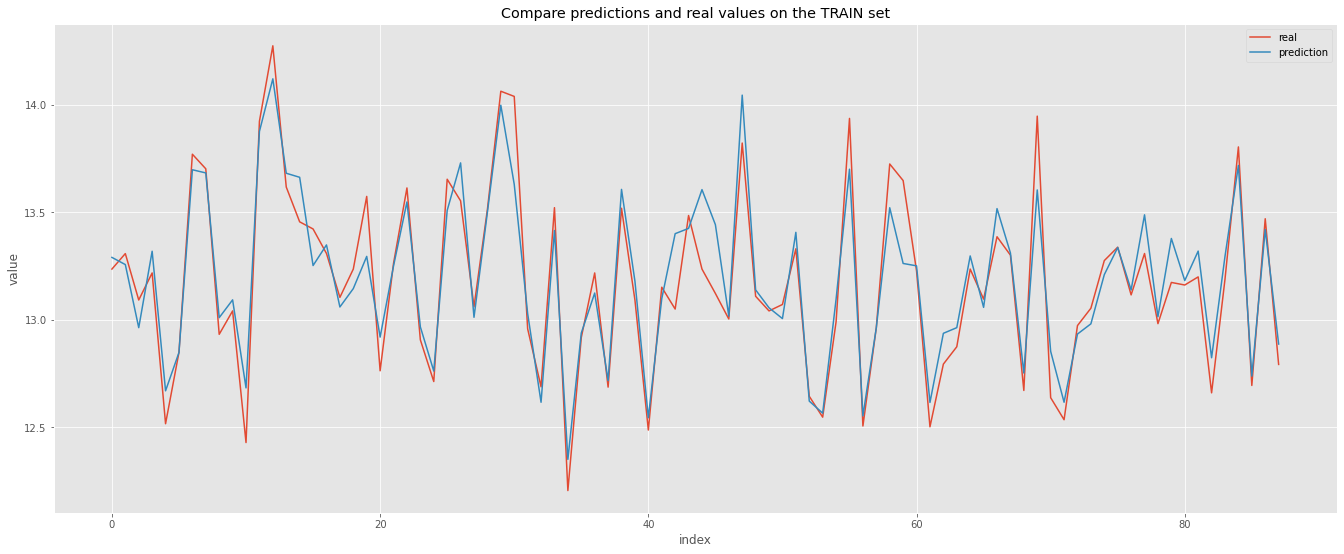

In [14]:
train = df2.loc[df2['datesold_year'] < 2019]
test = df2.loc[df2['datesold_year'] == 2019]

X_train = train.drop('price', axis=1)

y_train = train[['price']]
X_test = test.drop('price', axis=1)
y_test = test['price']

model = CatBoostRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

compare_preds_real_df = pd.DataFrame([y_train['price'].tolist(), y_pred_train]).T
compare_preds_real_df.columns = ['real', 'prediction']
compare_preds_real_df = compare_preds_real_df.sample(frac=.01)
compare_preds_real_df = compare_preds_real_df.reset_index()
compare_preds_real_df = compare_preds_real_df.drop('index', axis=1)
compare_preds_real_df.plot(legend=True)
plt.xlabel('index')
plt.ylabel('value')
plt.title('Compare predictions and real values on the TRAIN set')

Even thought the number of trees is just 10, it might seem as overfitting. As we can see, the model captures peaks very well, but makes mistakes in fairly average values. Therefore, in the future it will be necessary to control the learning process with the help of a validation set. Anyway, we need to check the performance on the test set

### 2.5 Predict the test set

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A valu

MAPE: 17.88%

MAE: 130094.95169371304


Text(0.5, 1.0, 'Compare predictions and real values on the TEST set')

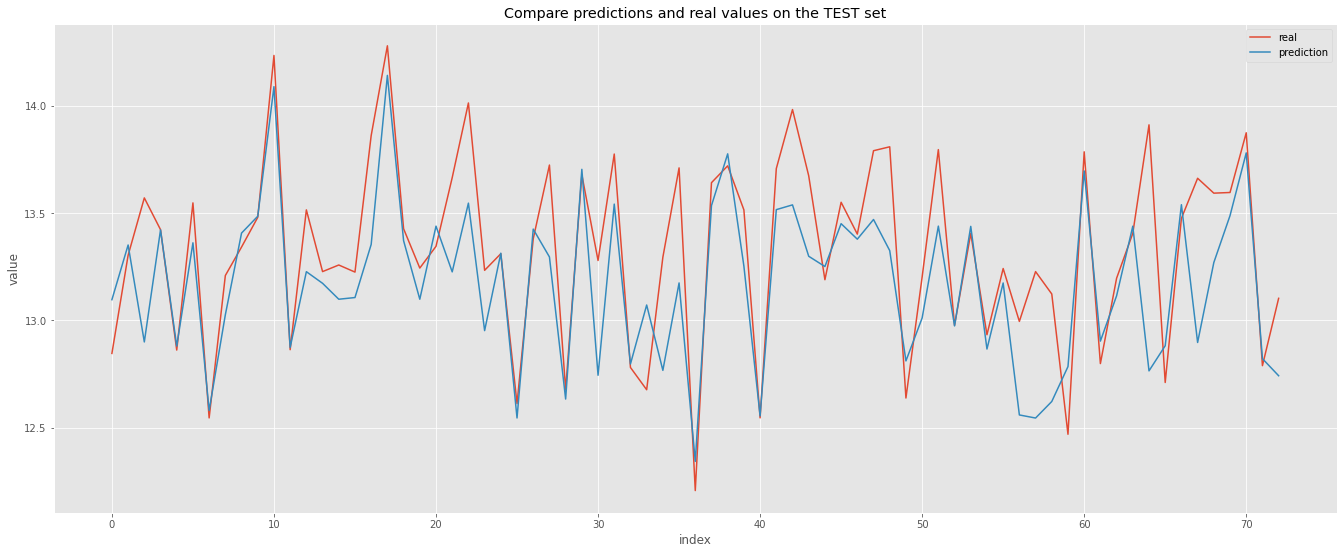

In [15]:
X_test.index = np.arange(0, len(X_test))
y_pred_test = []

for i in range(len(X_test)):
    
    pred = model.predict(X_test.iloc[i])
    
    month = X_test['month'][i]
    propertyType = X_test['propertyType'][i]
    bedrooms = X_test['bedrooms'][i]
    postcode = X_test['postcode'][i]
    
    y_pred_test.append(pred)
    
    for j in range(len(X_test)):
        
        if X_test['propertyType'][j] == propertyType\
        and X_test['bedrooms'][j] == bedrooms\
        and X_test['postcode'][j] == postcode:
            
            if X_test['month'][j] == month + 1 and X_test['lag1'][j] == 0:
                X_test['lag1'][j] = pred
                
            elif X_test['month'][j] == month + 2 and X_test['lag2'][j] == 0:
                X_test['lag2'][j] = pred
                
            elif X_test['month'][j] == month + 3 and X_test['lag3'][j] == 0:
                X_test['lag3'][j] = pred
                
            elif X_test['month'][j] == month + 6 and X_test['lag6'][j] == 0:
                X_test['lag6'][j] = pred          
                
print(f'MAPE: {np.round(mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test)) * 100, 2)}%')
print()
print(f'MAE: {mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))}')
compare_preds_test_df = pd.DataFrame([y_test.tolist(), y_pred_test]).T
compare_preds_test_df.columns = ['real', 'prediction']
compare_preds_test_df = compare_preds_test_df.sample(frac=.15)
compare_preds_test_df = compare_preds_test_df.reset_index()
compare_preds_test_df = compare_preds_test_df.drop('index', axis=1)
compare_preds_test_df.plot(legend=True)
plt.xlabel('index')
plt.ylabel('value')
plt.title('Compare predictions and real values on the TEST set')

### 2.6 Interpretation of the results of the baseline model

As we see, the metrics became worse, compared to the first model. However, now the results are reliable. Furthermore, we see that the model recognizes the general trend quite well, even though it usually underpredicts the real values. Therefore, in the next jupyter notebook, we will try to understand why there are so many underpredictions, as well as to try making the quality of the model better by applying several more advanced tools

# References

1) https://github.com/Pyatachokk/hse_ts_course/blob/master/2023-spring/seminars/sem_02.ipynb - representing time series problem as an ordinary table one, approaches of using lag features to predict future 